In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext cython
%timeit

import numpy as np
import cython
import scipy
from scipy import signal
import numpy as np
import os
import subprocess

import matplotlib
from matplotlib import pyplot as plt

TIMEIT = False

+### what to optimize

The `benchmarks.txt` we can see that the 3 most costly lines
in the fit function of ThetaScan are:

- seasonal_decompose (79.8 %)
- compute_ses (12.6 %)
- compute_trend (6.2 %)

Therefore those are the functions were most benefit will be achieved.

## `seasonal_decompose` (79.8 %)

The worst part of this function happens in the following function calls:

- `period_averages = np.array([np.nanmean(detrended[i::period], axis=0) for i in range(period)])`

- `trend = convolution_filter(y, period)`

In [2]:
np.random.seed(123)
detrended = np.random.random(20)
period = 5
period_averages = np.array([np.nanmean(detrended[i::period], axis=0) for i in range(period)])
period_averages

array([0.55018727, 0.54461124, 0.3814263 , 0.40586899, 0.51036458])

In [3]:
# the values in period_averages are computed as the mean over values
# that are period positions away starting from 0, 1, 2,...period-1

print(np.nanmean(detrended[0::period]))
print(np.nanmean(detrended[1::period]))
print(np.nanmean(detrended[2::period]))
print(np.nanmean(detrended[3::period]))
print(np.nanmean(detrended[4::period]))

0.5501872669013069
0.5446112427931341
0.38142629824404584
0.40586898525466475
0.5103645826017528


In [4]:
indices = [0,5,10,15]
values = np.array([detrended[j] for j in indices])
print(values)
print(detrended[0::period],'\n')

indices = [1,6,11,16]
values = np.array([detrended[j] for j in indices])
print(values)
print(detrended[1::period])

[0.69646919 0.42310646 0.34317802 0.73799541]
[0.69646919 0.42310646 0.34317802 0.73799541] 

[0.28613933 0.9807642  0.72904971 0.18249173]
[0.28613933 0.9807642  0.72904971 0.18249173]


In [5]:
np.array([np.nanmean(detrended[i::period], axis=0) for i in range(period)])

array([0.55018727, 0.54461124, 0.3814263 , 0.40586899, 0.51036458])

We want to iterate over the data only once tom compute the value in `period_averages`.


Note that `period_averages` is an array of dimension equal to period.

Thefore we can start with an array of lenght period that we will fill while we scan the data. 

In [6]:
period_averages

array([0.55018727, 0.54461124, 0.3814263 , 0.40586899, 0.51036458])

In [7]:
def compute_period_averages(array, period):
    acum_sum = np.zeros(period)
    acum_count = np.zeros(period)
    
    for k in range(len(array)):
        counter_pos = k%period
        acum_sum[counter_pos] += array[k]
        acum_count[counter_pos] +=1
        
    return acum_sum/ acum_count

In [8]:
period = 5

y = [7,8,9,10,11,12,13]
#   [X,0,0,0 ,0 ,X, 0]  -> [7, 12]
#   [0,X,0,0 ,0 ,0, X]  -> [8, 13]
#   [0,0,X,0 ,0 ,0, X]  -> [9]

print(y[0::period], y[1::period], y[2::period])
print(np.mean(y[0::period]), np.mean(y[1::period]), np.mean(y[2::period]))

[7, 12] [8, 13] [9]
9.5 10.5 9.0


In [77]:
compute_period_averages(y, period)

array([ 9.5, 10.5,  9. , 10. , 11. ])

We can see that **`compute_period_averages`** returns the same as our costly function

In [78]:
np.array([np.nanmean(y[i::period], axis=0) for i in range(period)])

array([ 9.5, 10.5,  9. , 10. , 11. ])

In [79]:
def original_period_averages(y, period):
    return np.array([np.nanmean(y[i::period], axis=0) for i in range(period)])

In [80]:
np.testing.assert_almost_equal(original_period_averages(y, period),
                               compute_period_averages(y, period))

In [81]:
if TIMEIT:
    %timeit np.array([np.nanmean(y[i::period], axis=0) for i in range(period)])
    %timeit compute_period_averages(y, period)

Let us try the function with an array that is much bigger


In [82]:
np.random.seed(123)
y = np.random.rand(1000)

In [83]:
compute_period_averages(y, period)

array([0.47432589, 0.49338989, 0.51265333, 0.52439152, 0.49210452])

In [84]:
np.array([np.nanmean(y[i::period], axis=0) for i in range(period)])

array([0.47432589, 0.49338989, 0.51265333, 0.52439152, 0.49210452])

In [85]:
if TIMEIT:
    %timeit original_period_averages(y,period)
    %timeit compute_period_averages(y, period)

Now we see that our non compiled function is slower.

Therefore, our function is not efficient for both small and big inputs.

Let us compile the function to achieve higher performance.

In [86]:
%%cython -a
cimport numpy as cnp
import numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(False) 
def compute_period_averages_cy(cython.floating[:] x, int period):
    cdef cython.floating[:] p_sum = np.zeros(period)
    cdef cython.floating[:] p_count = np.zeros(period)
    cdef int k, counter_pos
    cdef int n_x = len(x)
    
    for k in range(n_x):
        counter_pos = k % period
        p_sum[counter_pos] += x[k]
        p_count[counter_pos] += 1
    
    return np.array(p_sum)/ np.array(p_count)

In [147]:
np.testing.assert_almost_equal(original_period_averages(y, period),
                               compute_period_averages_cy(y, period))

In [92]:
if TIMEIT:
    %timeit original_period_averages(y, period)
    %timeit compute_period_averages_cy(y, period)

In [4]:
%%cython -a
cimport numpy as cnp
import numpy as np
cimport cython
from libc.math cimport isnan

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True) 
def compute_period_averages_cy2(cython.floating[:] array, int period):
    cdef cython.floating[:] acum_sum = np.zeros(period)
    cdef cython.floating[:] acum_count = np.zeros(period)
    cdef int k, counter_pos
    cdef cython.floating x_k
    
    for k in range(len(array)):
        counter_pos = k % period
        
        x_k = array[k]
        if not isnan(x_k):
            acum_sum[counter_pos] += x_k
            acum_count[counter_pos] += 1

    for k in range(period):
        acum_sum[k]/= acum_count[k]
        
    return np.array(acum_sum)

In [137]:
np.testing.assert_almost_equal(original_period_averages(y, period),
                               compute_period_averages_cy2(y, period))

In [142]:
if True:
    %timeit original_period_averages(y, period)
    %timeit compute_period_averages_cy2(y, period)

127 µs ± 4.72 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.27 µs ± 97.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
import copy

y_cop = copy.deepcopy(y)
y_cop[0] = np.nan

np.testing.assert_almost_equal(original_period_averages(y_cop, period),
                               compute_period_averages_cy2(y_cop, period))


NameError: name 'y' is not defined

###  `compute_ses`

In [9]:

def compute_ses(y, alpha):
    nobs = len(y)  

    # Forecast Array
    fh = np.full(nobs + 1, np.nan)  
    fh[0] = y[0]  
    fh[1] = y[0]  

    # Simple Exponential Smoothing
    for t in range(2, nobs + 1):
        fh[t] = alpha * y[t - 1] + (1 - alpha) * fh[t - 1]  # s[t] = alpha * y....

    return (fh[:nobs], fh[nobs])

In [13]:
%%cython -a
cimport numpy as cnp
import numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef compute_ses_cy(cython.floating[:] y, cython.floating alpha):
    cdef int n_obs = len(y)  
    cdef int t
    cdef cython.floating[:] fh = np.empty(n_obs + 1)
    cdef cython.floating alpha_y, alpha_fh

    fh[0] = y[0]
    fh[1] = y[0]
    
    for t in range(2, n_obs + 1):
        fh[t] = alpha * y[t - 1] + (1 - alpha) * fh[t - 1]
        
    return (fh[:n_obs], fh[n_obs])

In [19]:
np.random.seed(123)
y = np.random.random(1000)

In [12]:
if True:
    time_compute_ses = %timeit -o compute_ses(y, 0.05)
    time_compute_ses_cy = %timeit -o compute_ses_cy(y, 0.05)
    res = time_compute_ses.average / time_compute_ses_cy.average
    print(f'time improvement compute_ses cython: {res} X')

571 µs ± 9.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.99 µs ± 57.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
time improvement compute_ses cython: 81.6314140666947 X


In [ ]:
compute_ses_cy(y, 0.05)[1] == compute_ses(y, 0.05)[1]

### `convolution_filter`


```

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    90                                           @profile
    91                                           def convolution_filter(y, period):
    92                                               # Prepare Filter
    93     12943       9848.0      0.8      0.3      if period % 2 == 0:
    94      6469      61609.0      9.5      2.1          filt = np.array([.5] + [1] * (period - 1) + [.5]) / period
    95                                               else:
    96      6474      75548.0     11.7      2.6          filt = np.repeat(1. / period, period)
    97                                           
    98                                               # Signal Convolution
    99     12943     828685.0     64.0     28.5      conv_signal = signal.convolve(y, filt, mode='valid')
   100                                           
   101                                               # Padding (2-Sided Convolution)
   102     12943      45631.0      3.5      1.6      trim_head = int(np.ceil(len(filt) / 2.) - 1) or None
   103     12943      30392.0      2.3      1.0      trim_tail = int(np.ceil(len(filt) / 2.) - len(filt) % 2) or None
   104                                           
   105     12943       7479.0      0.6      0.3      if trim_head:
   106     12760     962702.0     75.4     33.1          conv_signal = np.r_[conv_signal, [np.nan] * trim_tail]
   107     12943       8015.0      0.6      0.3      if trim_tail:
   108     12760     869717.0     68.2     29.9          conv_signal = np.r_[[np.nan] * trim_head, conv_signal]
   109                                           
   110     12943       7433.0      0.6      0.3      return conv_signal
   ```


In [6]:

def convolution_filter(y, period):
    # Prepare Filter
    if period % 2 == 0:
        filt = np.array([.5] + [1] * (period - 1) + [.5]) / period
    else:
        filt = np.repeat(1. / period, period)

    # Signal Convolution
    conv_signal = scipy.signal.convolve(y, filt, mode='valid')

    # Padding (2-Sided Convolution)
    trim_head = int(np.ceil(len(filt) / 2.) - 1) or None
    trim_tail = int(np.ceil(len(filt) / 2.) - len(filt) % 2) or None

    if trim_head:
        conv_signal = np.r_[conv_signal, [np.nan] * trim_tail]
    if trim_tail:
        conv_signal = np.r_[[np.nan] * trim_head, conv_signal]

    return conv_signal

In [7]:
if TIMEIT:
    %timeit res = convolution_filter(y,4)

In [8]:
period = 4

def get_filt(period):

    if period % 2 == 0:
        filt = np.array([.5] + [1] * (period - 1) + [.5]) / period
    else:
        filt = np.repeat(1. / period, period)
    
    return filt

print(f'len_filter={len(get_filt(2))}',get_filt(2))
print(f'len_filter={len(get_filt(3))}',get_filt(3))
print(f'len_filter={len(get_filt(4))}',get_filt(4))
print(f'len_filter={len(get_filt(5))}',get_filt(5))
print(f'len_filter={len(get_filt(6))}',get_filt(6))

len_filter=3 [0.25 0.5  0.25]
len_filter=3 [0.33333333 0.33333333 0.33333333]
len_filter=5 [0.125 0.25  0.25  0.25  0.125]
len_filter=5 [0.2 0.2 0.2 0.2 0.2]
len_filter=7 [0.08333333 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.08333333]


#### Filter creation 
Note that 

```
[.5] + [1] * (period - 1) + [.5]
```


Creates a list of length `period -1 + 2` with elements `[0.5, 1,1,1,...,1,0.5]`.
Note that this approach with list of a single element multiplied by an integer is faster than using `np.ones`.

In [9]:
%timeit [1] * (500 - 1) 

1.32 µs ± 27.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
%timeit np.ones(500-1)

1.93 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
period = 4
print([0.5] +[1] * (period - 1) + [0.5])
print(np.array([0.5] +[1] * (period - 1) + [0.5])/period)

[0.5, 1, 1, 1, 0.5]
[0.125 0.25  0.25  0.25  0.125]


 If the len of the filter is
 
- **odd**, then filter[0] and filter[-1] are halve the value that is not in the extremes

- **even**, then all values in filter are the same



In [12]:
np.random.seed(123)
y = np.random.random(1000)

In [13]:
filt = get_filt(4)
%timeit conv_signal = scipy.signal.convolve(y, filt, mode='valid')

14.6 µs ± 471 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
filt = get_filt(100)
conv_signal = scipy.signal.convolve(y, filt, mode='valid')
conv_signal.shape

(900,)

In [15]:
conv_signal[0:10]

array([0.50051217, 0.5014979 , 0.50279561, 0.50008879, 0.49599925,
       0.4952041 , 0.4957251 , 0.49439595, 0.49560569, 0.49743689])

Let us compute the first values of conv_signal manually

In [16]:
def custom_convolve(y, kernel):
    n_kernel = len(kernel)
    result = []
    for i in range(len(y)-n_kernel+1):
        r = np.dot(y[i:i+n_kernel], kernel)
        result.append(r)
    return np.array(result)


In [17]:
custom_res = custom_convolve(y, filt)
print(len(custom_res), len(conv_signal))
np.testing.assert_almost_equal(custom_res, conv_signal)

900 900


In [18]:
%timeit custom_res = custom_convolve(y, filt)

1.12 ms ± 63.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
filt

array([0.005, 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.005])

#### Rethinking the computation by a dummy kernel


First we can compute the integral series `y_I` of `y` which contains at position `k` the sum `y[0:k]`.

We will do the function "by hand" in `integral_series` but this function is already in numpy and it is accessible with `np.cumsum`.


In [20]:
def integral_series(y):
    result = np.empty(len(y))
    current_sum = 0 
    for i in range(len(y)):
        current_sum += y[i]
        result[i] = current_sum
    return result

In [21]:
y_I = integral_series(y)

In [22]:
# we can verify that the integral series of position k equals the sum from 0 up to k.
# Note that in numpy x[i:j] goes from position i (with `i` included) up to position `j-1`
# so position j is not included. That is why we do y[0:10] instead of y[0:9].
np.sum(y[0:10])==y_I[9]

True

In [23]:
print(y_I[0:10])
print(np.cumsum(y)[0:10])

[0.69646919 0.98260852 1.20945997 1.76077474 2.48024371 2.90335017
 3.88411437 4.56894411 5.04987601 5.44199353]
[0.69646919 0.98260852 1.20945997 1.76077474 2.48024371 2.90335017
 3.88411437 4.56894411 5.04987601 5.44199353]


In [24]:
np.sum(y[10:20]), y_I[19] -y_I[9]

(4.127839973426267, 4.1278399734262665)

In [25]:
np.sum(y[15:20]), y_I[19] -y_I[14]

(2.1593178532717325, 2.159317853271731)

Using this new `y_I` we can realize that the computation of `np.dot(y[i:i+n_kernel], kernel)` equals to `alpha * (y[i+n_kernel]-y[i])`

In [26]:
len(filt)

101

In [27]:
np.dot(filt[1:-1],y[1:1+len(filt[1:-1])]) + filt[0]*y[0] + filt[100]*y[100]

0.5005121748944868

In [28]:
custom_res[0]

0.5005121748944868


Note that the first part of the expression

```python
np.dot(filt[1:-1], y[1:1+len(filt[1:-1])])
```
can be computed as 
```python
(y_I[len(filt[1:])] - y_I[2]) * filt[1]
```

In [34]:
period = 100
begin = 0
aux1 = (y_I[len(filt[1:])] - y_I[2]) * filt[1]
aux0 = (y_I[begin+period] - y_I[begin+2]) * filt[1]
aux2 = np.dot(filt[1:-1], y[1:1+len(filt[1:-1])])
assert abs(aux1 - aux2) < 0.00001
assert abs(aux0 - aux2) < 0.00001

In [35]:
%timeit np.dot(filt[1:-1], y[1:1+len(filt[1:-1])])

1.69 µs ± 31.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [36]:
begin = 0
%timeit (y_I[begin+period] - y_I[begin+2]) * filt[1]

529 ns ± 20 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Now let us think the same expression but instead of starting at 0 start at a position `begin`.


In [217]:
pos = 1
period = 100
begin = pos
end = pos+period-1
aux1 = (y_I[end-1] - y_I[begin-1]) * filt[1]
aux2 = np.dot(filt[1:-1], y[begin:end])
print(aux1, aux2)
assert abs(aux1 - aux2) < 0.00001

0.4944641881955026 0.49446418819550253


The rest of the expression
```python
filt[0]*y[0] + filt[100]*y[100]
```

Is simply

```
y[0]/period + y[100]/period
```



In [38]:
first_last_scalar = 0.5/period
(y[0]+y[period]) *first_last_scalar

0.006047986698984319

In [39]:
0.5*(y[0]/period +y[period]/period)

0.006047986698984318

In [40]:
(y[0] + y[period])*filt[period]

0.006047986698984319

In [49]:
def get_first_last_scalar(period):
    return (0.5)/(period)

one_over_period = 1/period
first_last_scalar = get_first_last_scalar(period)

In [214]:
# position can go from 1 to len series - period
pos = 2
period = 100
begin = pos
end = pos+period-1
aux1 = (y_I[end-1] - y_I[begin-1]) * filt[1]

alternative_res  = aux1 + (y[pos-1] + y[period]) *first_last_scalar 

In [215]:
alternative_res, custom_res[0]

(0.5007304138337358, 0.5005121748944868)

#### Putting it all together

In [307]:
def weighted_average_custom(y, y_I, period, pos):
    aux2 = (y[pos]+y[pos+period]) *(0.5/period)    
    pos = pos+1
    end = pos + period -1
    aux1 = (y_I[end-1] - y_I[pos-1]) 

    return aux1/period + aux2

In [308]:
def custom_convolve_fast(y, period):
    y_I = np.cumsum(y)
    result = np.empty(len(y)-period)
    for i in range(len(result)-2):
        result[i] = weighted_average_custom(y, y_I, period, i)
    return result


In [309]:
custom_res2 = custom_convolve_fast(y,100)

In [310]:
print(custom_res[0:4])
print(custom_res2[0:4])

[0.50051217 0.5014979  0.50279561 0.50008879]
[0.50051217 0.5014979  0.50279561 0.50008879]


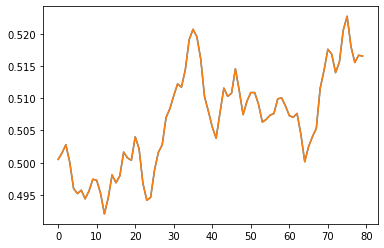

In [311]:
plt.plot(custom_res[0:80])
plt.plot(custom_res2[0:80])

In [303]:
y_I = np.cumsum(y)

def custom_convolve_fast2(y, y_I, period):
    result = np.empty(len(y)-period)
    for i in range(len(result)-2):
        result[i] = weighted_average_custom(y, y_I, period, i)
    return result



In [304]:
%timeit custom_convolve_fast2(y, y_I, period)

1.28 ms ± 19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [316]:
y_I_D = {p:y_I[p] for p in range(len(y_I))}

In [318]:
%timeit y_I_D[100]

28.5 ns ± 1.18 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [295]:
%timeit custom_convolve_fast(y, period)

1.2 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [296]:
def compute_conv_signal(y, period):
    if period % 2 == 0:
        filt = np.array([.5] + [1] * (period - 1) + [.5]) / period
    else:
        filt = np.repeat(1. / period, period)

    conv_signal = scipy.signal.convolve(y, filt, mode='valid')
    return conv_signal


In [297]:
conv_signal =  compute_conv_signal(y, period) 
conv_signal_custom = custom_convolve_fast(y, period)

In [298]:
%timeit custom_convolve_fast(y, period)

1.3 ms ± 45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [290]:
%timeit compute_conv_signal(y, period)

52.8 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### asume filter has all position same value

### Modify result with nans at beginning and end

In [45]:
filt = get_filt(100)
filt

array([0.005, 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.005])

In [52]:
filt = get_filt(100)
conv_signal = scipy.signal.convolve(y, filt, mode='valid')
conv_signal.shape

(900,)

In [54]:
conv_signal.shape

(900,)

In [56]:
conv_signal

array([0.50051217, 0.5014979 , 0.50279561, 0.50008879, 0.49599925,
       0.4952041 , 0.4957251 , 0.49439595, 0.49560569, 0.49743689,
       0.49726854, 0.49526267, 0.49205129, 0.49456101, 0.49811132,
       0.49688633, 0.4979385 , 0.5016492 , 0.50073529, 0.50037357,
       0.50401086, 0.50215658, 0.49678777, 0.49417288, 0.49461515,
       0.49881585, 0.50159798, 0.50275722, 0.50700397, 0.50838722,
       0.51039903, 0.51223071, 0.51171672, 0.5144268 , 0.51907615,
       0.52070013, 0.51954564, 0.51611138, 0.51019953, 0.50796155,
       0.50553805, 0.50379114, 0.50774884, 0.51157122, 0.51029762,
       0.51076849, 0.51457798, 0.51118722, 0.50744838, 0.50952618,
       0.51088447, 0.51088431, 0.50907497, 0.50629936, 0.50671886,
       0.50736771, 0.50764331, 0.50991535, 0.5100524 , 0.5088062 ,
       0.50730023, 0.50704053, 0.50764002, 0.50439479, 0.50014751,
       0.50250739, 0.50403255, 0.50531902, 0.51152104, 0.51431155,
       0.51759924, 0.51684801, 0.51397782, 0.51562896, 0.52058

In [57]:

# Padding (2-Sided Convolution)
trim_head = int(np.ceil(len(filt) / 2.) - 1) or None
trim_tail = int(np.ceil(len(filt) / 2.) - len(filt) % 2) or None

if trim_head:
    conv_signal = np.r_[conv_signal, [np.nan] * trim_tail]
if trim_tail:
    conv_signal = np.r_[[np.nan] * trim_head, conv_signal]

In [58]:
trim_head, trim_tail

(50, 50)

In [59]:
conv_signal.shape

(1000,)